In [1]:
import os
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import cv2
import uuid

In [2]:
from keras.layers import Dense, Conv2D, GlobalAveragePooling2D, MaxPool2D, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.layers import Flatten
from keras.models import Model  #the functional API

In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# **Making required directories**

In [4]:
#setting up the directory structure for our project. Namely, three folders Anchor, Negative, Positive
pos_path = os.path.join('data', 'positive')         #positive images (verification images)
neg_path = os.path.join('data', 'negative')         #negative images (different from the anchor images)
anc_path = os.path.join('data', 'anchor')           #input image (object to be recognized)

In [ ]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)
#first, we collect the negative examples through Labelled Faces in the wild repository
! tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(neg_path, file)
        os.replace(EX_PATH, NEW_PATH)

"""
first we loop over every sub directory in the lfw folder. Then for every file in each sub directory, we get the path of the file, create a new path for the
file and the replace the two paths (in effect cutting the files from the initial location to the final location)"""

# **Writing a function to capture User's image through the webcam**

In [5]:
#capturing the anchor and the positive images using our webcam and opencv
#step1. establish a connection to the webcam using VideoCapture()
cap = cv2.VideoCapture(-1)
while cap.isOpened():
    ret, frame = cap.read()
    cv2.imshow("Image Collection", frame)
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break
#Release the webcam and destroy the image show frame
cap.release()
cv2.destroyAllWindows()

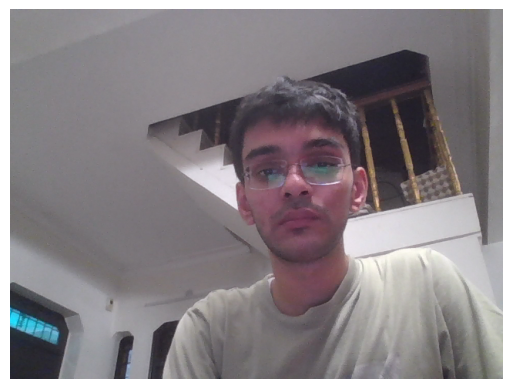

In [6]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()
#this is actually the last frame captured by the camera before i pressed q (as soon as it is pressed, the image capture stops)

In [6]:
#However, the resolution is large and needs to be reduced for processing
#for this we make a change to the original image capturing function
#capturing the anchor and the positive images using our webcam and opencv
#step1. establish a connection to the webcam using VideoCapture()
cap = cv2.VideoCapture(-1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:370, 200:450, :]  #arbitrary values
    #collecting anchor images
    if(cv2.waitKey(1) & 0XFF == ord('a')):
        imgname = os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    #collecting positive images
    if(cv2.waitKey(1) & 0XFF == ord('p')):
        imgname = os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)

    cv2.imshow("Image Collection", frame)
    if(cv2.waitKey(1) & 0XFF == ord('q')):
        break
#Release the webcam and destroy the image show frame
cap.release()
cv2.destroyAllWindows()

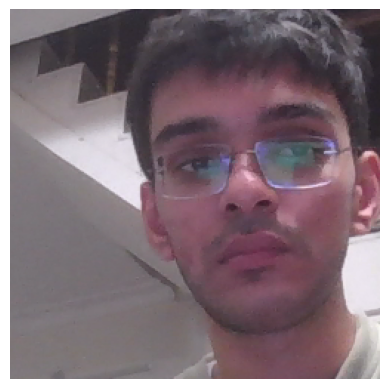

In [8]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis(False)
plt.show()
#last image captured by the camera. Also, in this case, the resolution is smaller than the pervious case

In [7]:
def data_aug(img):
    data = []
    for i in range(5):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [8]:
for file_name in os.listdir(os.path.join(pos_path)):
    img_path = os.path.join(pos_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(pos_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [9]:
for file_name in os.listdir(os.path.join(anc_path)):
    img_path = os.path.join(anc_path, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(anc_path, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# **Image Preprocessing for the Neural Network**

### 1. Getting the image directories

In [10]:
anchor = tf.data.Dataset.list_files(anc_path +"/*.jpg").take(4000)
positive = tf.data.Dataset.list_files(pos_path +"/*.jpg").take(4000)
negative = tf.data.Dataset.list_files(neg_path +"/*.jpg").take(4000)

In [11]:
#to create a performant data pipeline, we first create a function which is mapped to the entire dataset
def preprocess(file_path):
    #reading in image from filepath
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img/255.0   #rescaling for better learning
    return img

### Creating a labelled dataset

In [12]:
# (anchor, positive) = 1,1,1,1,1
# (anchor, negative) = 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [13]:
#visualizing what is happening
sample = data.as_numpy_iterator()
sample.next()
#here, it has paired an anchor and a positive image and labelled the pair to be 1

(b'data/anchor/95f1dd22-2185-11ee-87fb-646ee070f8ff.jpg',
 b'data/positive/cbdd0750-2184-11ee-87fb-646ee070f8ff.jpg',
 1.0)

(-0.5, 99.5, 99.5, -0.5)

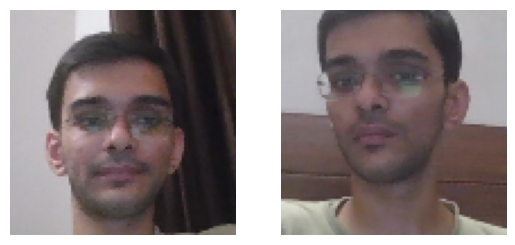

In [18]:
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*sample.next())
plt.subplot(1,2,1)
plt.imshow(res[0])
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(res[1])
plt.axis(False)

#this is an example of anchor and positive image

In [15]:
#building the data loader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size = 100000)

(-0.5, 99.5, 99.5, -0.5)

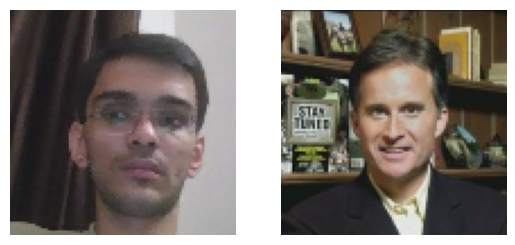

In [22]:
samples = data.as_numpy_iterator()
res = samples.next()
plt.subplot(1,2,1)
plt.imshow(res[0])
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(res[1])
plt.axis(False)

#this is an example of anchor and negative image

In [23]:
#splitting the entire data into training and testing data
train_data = data.take(round(len(data)*0.7))
train_data = train_data.batch(16).prefetch(tf.data.AUTOTUNE)
test_data = data.skip(round(len(data)*0.7))
test_data = test_data.take(round(len(data)*0.3))
test_data = test_data.batch(16).prefetch(tf.data.AUTOTUNE)

# **Building the Model**

In [24]:
def make_embedding():
    inp = Input(shape = (100,100,3))
    #first block
    x = Conv2D(filters = 64, kernel_size = (10,10), strides = 1, activation = "relu")(inp)
    x = BatchNormalization()(x)
    x = MaxPool2D(64, (2,2), padding = "same")(x)

    #second block
    x = Conv2D(filters = 128, kernel_size = (7,7), strides = 1, activation = "relu")(x)
    x = MaxPool2D(64, (2,2), padding = "same")(x)

    #third block
    x = Conv2D(filters = 128, kernel_size = (4,4), strides = 1, activation = "relu")(x)
    x = MaxPool2D(64, (2,2), padding = "same")(x)

    #fourth block
    x = Conv2D(filters = 256, kernel_size = (4,4), strides = 1, activation = "relu")(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4096, activation = "sigmoid")(x)

    return Model(inputs = [inp], outputs = [outputs] , name = "embedding")

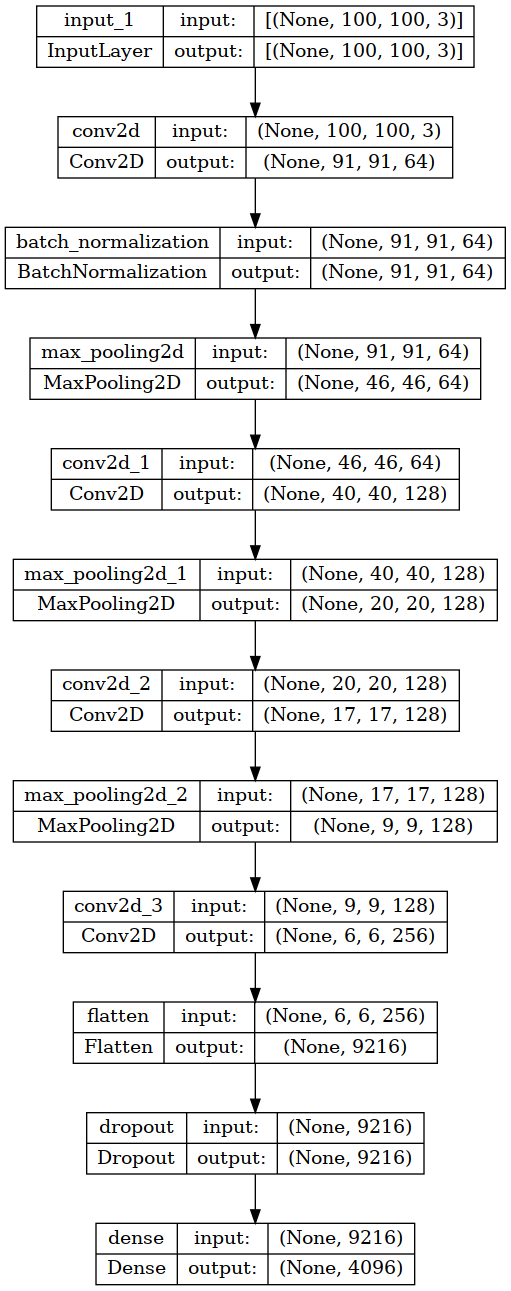

In [25]:
model = make_embedding()
from keras.utils import plot_model
plot_model(model, show_shapes = True)

### **Building the distance layer**

In [26]:
#Siamese L1 distance class
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

### **Making the Siamese Model**

In [27]:
embedding = make_embedding()
def make_siamese_model():

    #Handle inputs
    input_image = Input(name = "input_image", shape = (100,100,3))                  #anchor image
    validation_image = Input(name = "validation_image", shape = (100,100,3))         #negative or positive

    #combine Siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    #classification layer
    classifier = Dense(1, activation = "sigmoid")(distances)
    return Model(inputs = [input_image, validation_image], outputs = classifier, name = "SiameseNetwork")

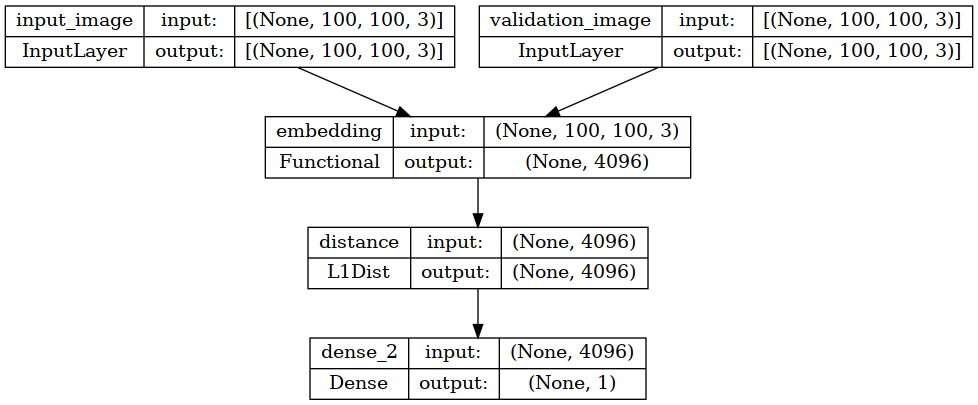

In [28]:
siamese_model = make_siamese_model()
plot_model(siamese_model, show_shapes = True)

# **Setting up Training Parameters**

In [29]:
test_sample = train_data.as_numpy_iterator().next()
print(np.array(test_sample[:2]).shape)
#2 corresponds to both validation and input image (say anchor and positive or anchor and negative)
#16 refers to the batch size
#100, 100, 3 refers to the size of the image

(2, 16, 100, 100, 3)


In [30]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(0.0001)

#establish checkpoints
checkpoint_dir = "./training checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "chkpt")
checkpoint = tf.train.Checkpoint(opt = optimizer, siamese_model = siamese_model)



#building the train step function (what happens when a mini batch is completely trained)
@tf.function   #compiles a function into a callable tensorflow graph
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        y = batch[2]

        yhat = siamese_model(X, training = True)
        loss = binary_cross_loss(y, yhat)
    #calculate the gradients. Gradient Tape records the order in which operations happened during ForwardProp and uses that to find gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    optimizer.apply_gradients(zip(grad, siamese_model.trainable_variables))           #updates to the weights
    return loss

In [31]:
from keras.metrics import Precision, Recall

In [32]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            
        progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [ ]:
EPOCHS = 10
train(train_data, EPOCHS)

In [34]:
from keras.metrics import Precision, Recall
test_input, test_val, y_true = test_data.as_numpy_iterator().next()
print(test_input.shape)
yhat = siamese_model.predict([test_input, test_val])
print(yhat)

(16, 100, 100, 3)
1/1 [==============================] - 0s 51ms/step
[[6.6532158e-10]
 [1.0000000e+00]
 [1.2581800e-06]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.7161249e-09]
 [1.4024141e-09]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]
 [1.0000000e+00]]


In [35]:
#post processing the results of the model
[1 if prediction > 0.5  else 0 for prediction in yhat]  #list comprehension

[0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]

In [36]:
print(y_true)   #as we can see, the predictions and the model actually line up pretty well for this example

[0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]


## Save Weights

In [37]:
siamese_model.save('siamesemodel.h5')
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects = {'L1Dist': L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [38]:
yhat = siamese_model.predict([test_input, test_val])
prediction = []
true = []
for input_image, validation_image, y_true in test_data:
    prediction.append(tf.squeeze(siamese_model.predict([input_image, validation_image])))
    true.append(tf.squeeze(y_true))

1/1 [==============================] - 0s 19ms/step


In [39]:
print(len(true))
print(len(prediction))
true_final = []
for x in true:
    for elem in x:
        true_final.append(int(elem.numpy()))
print(true_final[:10])
prediction_final = []
for y in prediction:
    for elem in y:
        prediction_final.append(elem.numpy())
prediction_final = [1 if prediction > 0.5  else 0 for prediction in prediction_final]
print(prediction_final[:10])

150
150
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1]
[1, 0, 1, 1, 0, 1, 1, 0, 0, 1]


In [40]:
true_final == prediction

False

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_true = true_final, y_pred =prediction_final, digits = 2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1181
           1       1.00      1.00      1.00      1219

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



In [42]:
true_final == prediction_final

True

# **Real Time test**

In [43]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 20ms/step
1.0 1.0


In [44]:
os.listdir(os.path.join('application_data', 'verification_images'))
os.path.join('application_data', 'input_image', 'input_image.jpg')
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

application_data/verification_images/1d73fa02-210c-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/1e18ad30-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/1cceab96-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/1d01ca26-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/4d510d4a-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/c86d9846-210c-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/2c8b9760-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/2d244d02-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/4ce707a6-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/2a3a2530-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/d62a1658-210c-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/1ebb1958-210d-11ee-8957-646ee070f8ff.jpg
application_data/verification_images/d98e5c3c-210c-11ee-8957-646

In [45]:
cap = cv2.VideoCapture(-1)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
False
1/1 [==============================] - 0s 18ms/step
False
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 16ms/step
True
1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 16ms/step
True
1/1 [==============================] - 0s 18ms/step
True
1/1 [==============================] - 0s 17ms/step
False
1/1 [==============================] - 0s 15ms/step
False
1/1 [==============================] - 0s 14ms/step
False
1/1 [==============================] - 0s 20ms/step
False


In [46]:
np.sum(np.squeeze(results) > 0.9)

8

In [47]:
results

[array([[0.99999595]], dtype=float32),
 array([[0.00935358]], dtype=float32),
 array([[0.00016981]], dtype=float32),
 array([[0.7188432]], dtype=float32),
 array([[0.00043284]], dtype=float32),
 array([[0.0735474]], dtype=float32),
 array([[0.9263298]], dtype=float32),
 array([[0.73317415]], dtype=float32),
 array([[0.00272401]], dtype=float32),
 array([[0.00226643]], dtype=float32),
 array([[0.00039924]], dtype=float32),
 array([[0.01398275]], dtype=float32),
 array([[5.70838e-05]], dtype=float32),
 array([[0.00032972]], dtype=float32),
 array([[0.00032883]], dtype=float32),
 array([[0.9999969]], dtype=float32),
 array([[0.00031858]], dtype=float32),
 array([[0.00125211]], dtype=float32),
 array([[0.00387744]], dtype=float32),
 array([[0.00045836]], dtype=float32),
 array([[0.00189079]], dtype=float32),
 array([[0.9999784]], dtype=float32),
 array([[0.9938736]], dtype=float32),
 array([[0.00130408]], dtype=float32),
 array([[0.98135614]], dtype=float32),
 array([[2.9887216e-05]], dtyp